
<font color = lightblue> Curso ***IDASE*** - ___Inteligência de Dados Aplicada ao Setor Elétrico___

Disciplina ___Inteligência Artificial___

Doscente: _Dr. Augusto Santiago Cerqueira_

Discente: _Giovani Santiago Junqueira_

# <font color = green>***Análise de Dados e Projeto de um Classificador***</font>

***Objetivo Principal:*** Desenvolver classificadores para o conjunto de dados “Breast Cancer Wisconsin (Diagnostic)” da UCI. https://archive.ics.uci.edu/static/public/17/breast+cancer+wisconsin+diagnostic.

Informações do conjunto de dados
Informações adicionais

Os recursos são computados a partir de uma imagem digitalizada de uma aspiração por agulha fina (FNA) de uma massa mamária. Eles descrevem características dos núcleos celulares presentes na imagem. Algumas das imagens podem ser encontradas em http://www.cs.wisc.edu/~street/images/

O plano de separação descrito acima foi obtido usando o Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], um método de classificação que usa programação linear para construir uma árvore de decisão. Os recursos relevantes foram selecionados usando uma busca exaustiva no espaço de 1-4 recursos e 1-3 planos de separação.

O programa linear real usado para obter o plano de separação no espaço tridimensional é o descrito em: [K. P. Bennett e O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

Este banco de dados também está disponível através do servidor ftp UW CS:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/


## <font color = lightgreen>Importação das bibliotecas necessárias

### <font color = lightyellow>Importando as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.spatial import distance
from imblearn.over_sampling import SMOTE

### <font color = lightyellow>Parametrizando os dados de entrada

In [2]:
data_id = 17 # Breast Cancer Wisconsin (Diagnostic)
test_size = 0.3 # Conjunto de teste = 30%
random_state = 42 # Semente para o gerador de números randômicos, garantindo a reprodutibilidade
n = 5 # Quantidades de parâmetros a ser utilizado
k = 10 # Número de visinhos mais próximos
max_inter = 1000 # número máximo de interações

### <font color = lightyellow> Carrega um conjunto de dados a partir do repositório UCI.</font>

Esta função recupera o conjunto de dados associados ao `data_id` fornecido e utiliza
a função `fetch_ucirepo` para extrair os `feaures`, os `targets`, as informações dos
metadados e as variáveis do conjunto de dado do repositório UCI, e então separa as
variáveis de entrada (`x`) da variável de saída (`y`). Ambas as variáveis são retornadas
como DataFrames do Pandas.

In [3]:
repository_dataset = fetch_ucirepo(id=data_id)
x = repository_dataset.data.features
y = repository_dataset.data.targets
metadata = repository_dataset.metadata # metadata
variables = repository_dataset.variables #variable information

In [4]:
print(metadata)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

In [5]:
print(variables)

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

## <font color = lightgreen>Pré-processamento

### <font color = lightyellow>Função para plotagem do mapa de calor

In [6]:
def heat_map(matrix, matrix_name):
    """ Gera e exibe um mapa de calor (heatmap) para a matriz fornecida.

    Args:
        matrix (array-like): A matriz de dados que será visualizada como um mapa de calor.
        matrix_name (str): O título que será exibido no topo do mapa de calor.
    """
    plt.figure(figsize=(12,8))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title(f"{matrix_name}")
    plt.show()

### <font color = lightyellow>Função para visualização da matriz de confusão

In [7]:
def disp_matriz(conf_matrix, class_name):
    """ Exibe a matriz de confusão fornecida utilizando uma visualização gráfica.

    Args:
        conf_matrix (array-like): A matriz de confusão que será exibida. Cada célula da matriz
        representa a contagem de classificações corretas e incorretas para cada classe.
        class_name (list de str): Os nomes das classes a serem exibidos nos rótulos da matriz
        de confusão.
    """
    _, ax = plt.subplots(figsize=(12,8))
    plt.title("Matriz Confusão")
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_name)
    disp.plot(ax=ax, cmap=plt.cm.Oranges)
    ax.set_xlabel('Classe Prevista', fontsize=14)
    ax.set_ylabel('Classe Real', fontsize=14)
    plt.show()

### <font color = lightyellow>Função para calcular os indicadores de desempenho 

In [8]:
def performance_indicators(y_test, y_pred):
    """ Calcula os indicadores de desempenho do modelo: acurácia, sensibilidade e especificidade/característica,
    além de retornar a matriz de confusão.

    Args:
        y_test (array-like): Rótulos reais do conjunto de teste.
        y_pred (array-like): Rótulos previstos pelo modelo.

    Return:
        list: Uma lista contendo os indicadores de desempenho [acurácia, sensibilidade, especificidade].
        array: Matriz de confusão resultante da comparação entre os rótulos reais e os previstos.
    
    Indicadores calculados:
        - Acurácia: A proporção de previsões corretas (verdadeiros positivos + verdadeiros negativos) sobre o total.
        - Sensibilidade: A taxa de verdadeiros positivos (quantos da classe positiva foram corretamente classificados).
        - Especificidade (ou característica): A taxa de verdadeiros negativos (quantos da classe negativa foram corretamente classificados).
    """
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sensitivity = (np.diag(conf_matrix) / conf_matrix.sum(axis=1)).mean()
    caracteristic =  (np.diag(conf_matrix) / conf_matrix.sum(axis=0)).mean()
    return [accuracy, sensitivity, caracteristic], conf_matrix

### <font color = lightyellow>***A*** - Dividindo os dados em treino e teste

`método do holdout`

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,
                                                        random_state=random_state, stratify=y)

### <font color = lightyellow>***B*** - Normaização nos dados de treino e aplicando-a nos dados de teste

In [10]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### <font color = lightyellow>***C*** - Utilizando o `SMOTE` para balanceamento das classes

In [11]:
x_train_bal, y_train_bal = SMOTE(random_state=random_state).fit_resample(x_train, y_train)

### <font color = lightyellow>***D*** - Codifinado as labels, transformando as classes em valores numéricos.

In [12]:
label_encoder = LabelEncoder()
y_train_bal = label_encoder.fit_transform(y_train_bal.values.ravel())
y_test = label_encoder.transform(y_test.values.ravel())

In [13]:
classes = label_encoder.inverse_transform(np.unique(y_train_bal))

In [14]:
classes

array(['B', 'M'], dtype=object)

### <font color = lightyellow>***E*** - Matriz de correlação de entrada e saída

In [15]:
correlation_matrix = pd.DataFrame(x_train_bal).corr()

In [16]:
correlations = pd.Series(np.corrcoef(x_train_bal.T, y_train_bal)[-1, :-1])
top_n_corr_features = correlations.abs().sort_values(ascending=False).head(n).index
x_train_corr = x_train_bal[:, top_n_corr_features]
x_test_corr = x_test[:, top_n_corr_features]

In [17]:
top_n_corr_features

Index([27, 22, 20, 7, 2], dtype='int64')

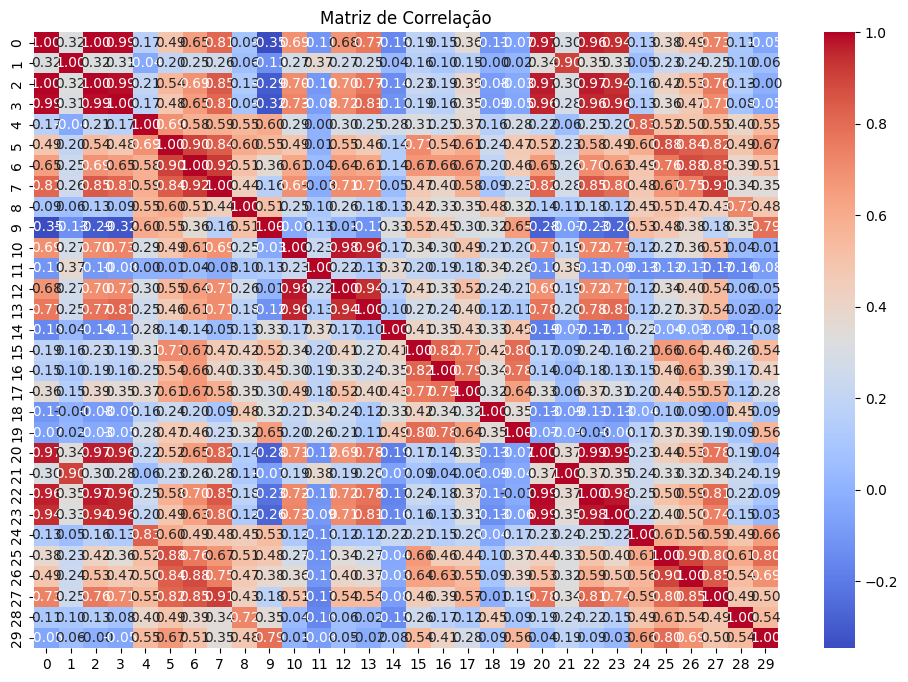

In [18]:
heat_map(correlation_matrix, "Matriz de Correlação")

### <font color = lightyellow>***F*** - Cálculo a informação mútua entre os parâmetros de entrada e a saída

In [19]:
mutual_info = mutual_info_classif(x_train_bal, y_train_bal)

In [20]:
top_n_mutual_info_features = np.argsort(mutual_info)[-n:]
x_train_mutual_info = x_train_bal[:, top_n_mutual_info_features]
x_test_mutual_info = x_test[:, top_n_mutual_info_features]

In [21]:
top_n_mutual_info_features

array([ 2, 23,  7, 20, 22])

### <font color = lightyellow>***G*** - Cálculo a razão discriminante de Fisher

In [22]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_bal, y_train_bal)
fisher_ratios = np.sum(np.abs(lda.coef_), axis=0)

In [23]:
top_n_fisher_features = np.argsort(fisher_ratios)[-n:]
x_train_fisher = x_train_bal[:, top_n_fisher_features]
x_test_fisher = x_test[:, top_n_fisher_features]

In [24]:
top_n_fisher_features

array([10,  3, 20,  0,  2])

### <font color = lightyellow>***H*** - Análise de Componentes Principais (PCA)

In [25]:
pca = PCA(n_components=n)
pca.fit(x_train_bal)
x_train_pca = pca.transform(x_train_bal)
x_test_pca = pca.transform(x_test)

In [26]:
top_n_pca_features = pca.components_

In [27]:
top_n_pca_features

array([[ 0.23331059,  0.09180187,  0.24121396,  0.23595605,  0.14114412,
         0.23449964,  0.2538129 ,  0.26954722,  0.12277072,  0.04712129,
         0.20817477,  0.00339474,  0.21147053,  0.209696  ,  0.01822064,
         0.15296816,  0.12682236,  0.16945711,  0.0373268 ,  0.08113128,
         0.24493164,  0.09758901,  0.25256086,  0.24265775,  0.12833585,
         0.20022311,  0.21760596,  0.25405836,  0.11172587,  0.11102166],
       [-0.22553094, -0.06298508, -0.2048188 , -0.22732726,  0.19221669,
         0.16868742,  0.09511498, -0.01238034,  0.21227814,  0.35535751,
        -0.10453236,  0.05287352, -0.08343443, -0.14678239,  0.17414209,
         0.23018961,  0.19734269,  0.13437016,  0.18010495,  0.25618608,
        -0.21257493, -0.04460828, -0.18728504, -0.21935013,  0.18043356,
         0.17302392,  0.13619315,  0.02143096,  0.17708163,  0.28593473],
       [-0.00649112,  0.04712544, -0.00719906,  0.02036674, -0.11619097,
        -0.0607542 ,  0.01544671, -0.03249434, -0

# <font color = green>***Atividade***</font>

- <font color = lightyellow>Projetar um classiﬁcardor baseado na `distância de Mahalanobis`;

  - utilizando todos os parâmetros existentes na base de dados;

  - Utilizando n parâmetros existentes na base de dados;

- Projetar um classificador baseado no`KNN (K-nearest neighbors)`;

  - utilizando todos os parâmetros existentes na base de dados;

  - Utilizando n parâmetros existentes na base de dados;

- Projetar um classificador baseado no `LDA (Linear Discriminant Analysis)`;

  - utilizando todos os parâmetros existentes na base de dados;

  - Utilizando n parâmetros existentes na base de dados;
  
  - <font color = lightyellow>Projetar um classiﬁcardor baseado em uma `rede neural MLP (Multilayer Perceptron)`;

  - utilizando todos os parâmetros existentes na base de dados;

- Projetar um classificador baseado em `máquinas de vetores de suporte não-linear (kernel função
de base radial)`;

  - utilizando todos os parâmetros existentes na base de dados;

## <font color = lightgreen>Projeto dos Classificadores

In [28]:
activity = pd.DataFrame(columns=['accuracy', 'sensitivity', 'caracteristic'], 
                        index=['mahalanobis','mahalanobis_corr', 'mahalanobis_mutual',
                               'mahalanobis_fisher', 'mahalanobis_pca', 'knn','knn_corr',
                               'knn_mutual','knn_fisher', 'knn_pca', 'lda','lda_corr',
                               'lda_mutual','lda_fisher', 'lda_pca', 'mlp', 'svm'])

### <font color = yellow> Classificadores baseado na Distância de Mahalanobis

#### <font color = lightyellow> ***00*** - Função para calcular a matriz de covariância e a distância de Mahalanobis

In [29]:
def mahalanobis_classifier(x_train_bal, x_test, y_train_bal, y_test):
    """ Implementa um classificador baseado na distância de Mahalanobis utilizando os dados de treino balanceados,
    realiza previsões nos dados de teste e avalia o desempenho do modelo.  

    Args:
        x_train (array-like): Dados de treino usados para treinar o modelo.
        x_test (array-like): Dados de teste usados para avaliar o modelo.
        y_train (array-like): Rótulos das classes correspondentes aos dados de treino balanceados.
        y_test (array-like): Rótulos das classes correspondentes aos dados de teste.

    Return:
        metrics (list): Uma lista contendo as seguintes métricas de desempenho:
            - accuracy (float): A precisão do modelo, calculada como a proporção de previsões corretas.
            - sensitivity (float): A sensibilidade do modelo, calculada como a média das taxas de verdadeiros positivos por classe.
            - specificity (float): A especificidade do modelo, calculada como a média das taxas de verdadeiros negativos por classe.
        conf_matrix (array-like): A matriz de confusão, que mostra o desempenho do modelo em termos de 
        verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
        
    Notas:
        A função calcula a distância de Mahalanobis entre cada amostra de teste e a média 
        de cada classe no conjunto de treino, utilizando a matriz de covariância do conjunto 
        e treino. A classe com a menor distância é atribuída à amostra.
    """
    cov_matrix = np.cov(x_train_bal, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    y_pred = []
    classes = np.unique(y_train_bal)
    for x in x_test:
        distances = []
        for c in classes:
            mean = np.mean(x_train_bal[y_train_bal == c], axis=0)
            distances.append(distance.mahalanobis(x, mean, inv_cov_matrix))
        y_pred.append(np.argmin(distances))
    return performance_indicators(y_test, y_pred)

#### <font color = lightyellow> ***01*** - Utilizando todos os parâmetros de entrada

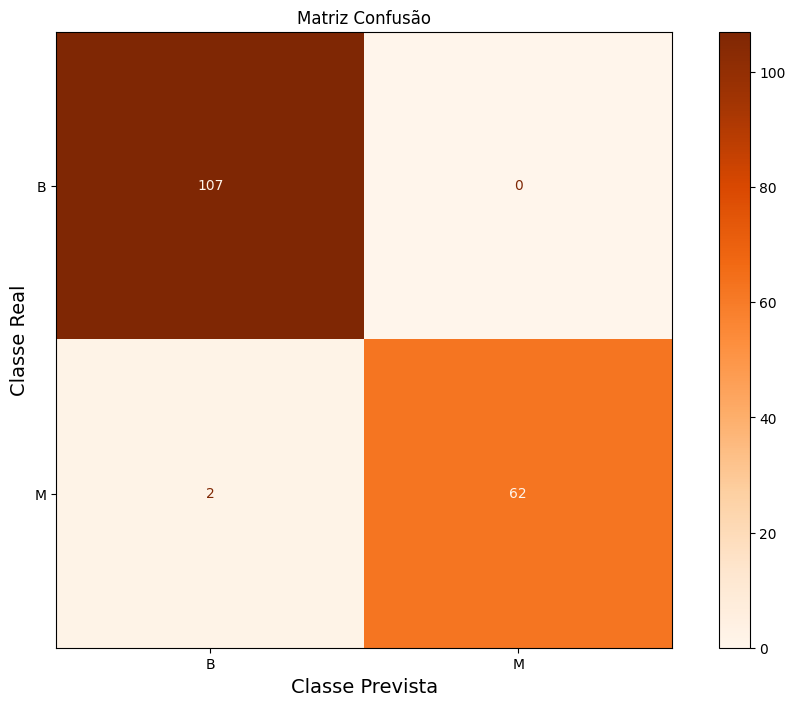

In [30]:
# avaliando o classificador com todos os parâmetros
activity.loc['mahalanobis'], conf_matrix_all = mahalanobis_classifier(x_train_bal, x_test, y_train_bal, y_test)

disp_matriz(conf_matrix_all, classes)

#### <font color = lightyellow> ***02*** - Utilizando os n parâmentros de maior correlação

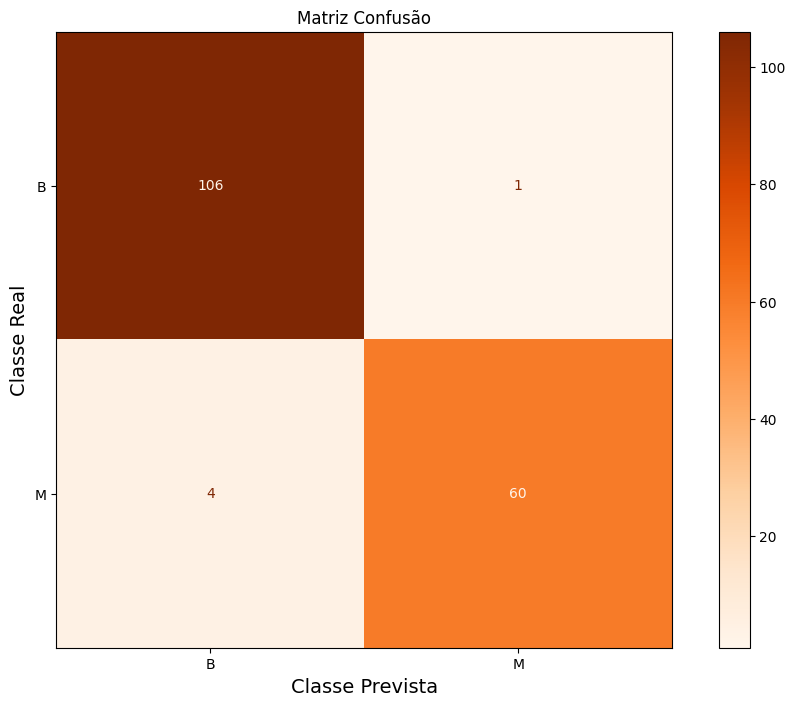

In [31]:
# Distância de Mahalanobis com n parâmetros de maior correlação
activity.loc['mahalanobis_corr'], conf_matrix_corr = mahalanobis_classifier(x_train_corr, x_test_corr, y_train_bal, y_test)

disp_matriz(conf_matrix_corr, classes)

#### <font color = lightyellow> ***03*** - Utilizando os n parâmentros de maior informação mútua

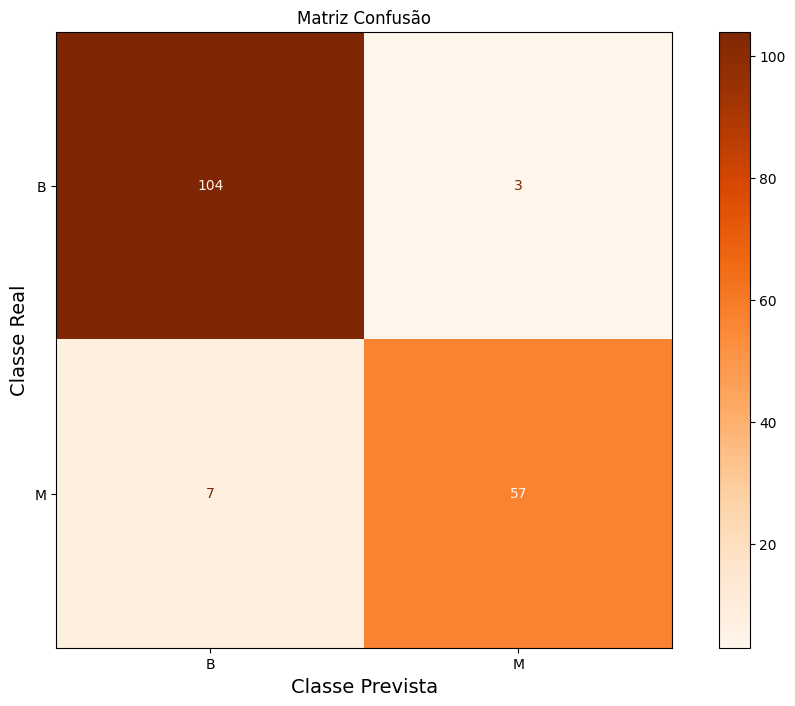

In [32]:
# Distância de Mahalanobis com n parâmetros de maior informação mútua
activity.loc['mahalanobis_mutual'], conf_matrix_mutual_info = mahalanobis_classifier(x_train_mutual_info, x_test_mutual_info, y_train_bal, y_test)

disp_matriz(conf_matrix_mutual_info, classes)

#### <font color = lightyellow> ***04*** - Utilizando os n parâmentros de maior discriminante de Fisher

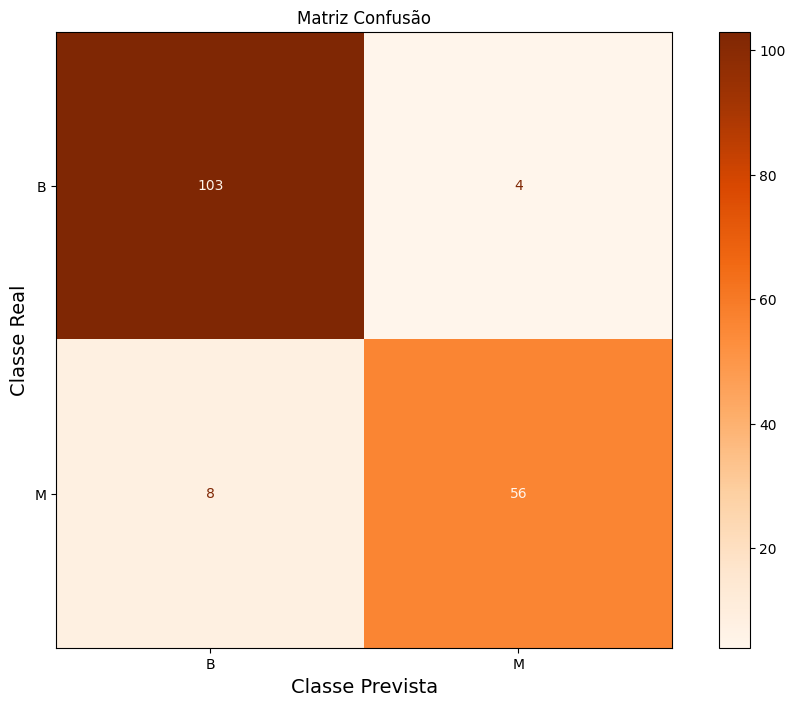

In [33]:
# Distância de Mahalanobis com n parâmetros de maior razão discriminante de Fisher
activity.loc['mahalanobis_fisher'], conf_matrix_fisher = mahalanobis_classifier(x_train_fisher, x_test_fisher, y_train_bal, y_test)

disp_matriz(conf_matrix_fisher, classes)

#### <font color = lightyellow> ***05*** - Utilizando os n parâmentros do PCA

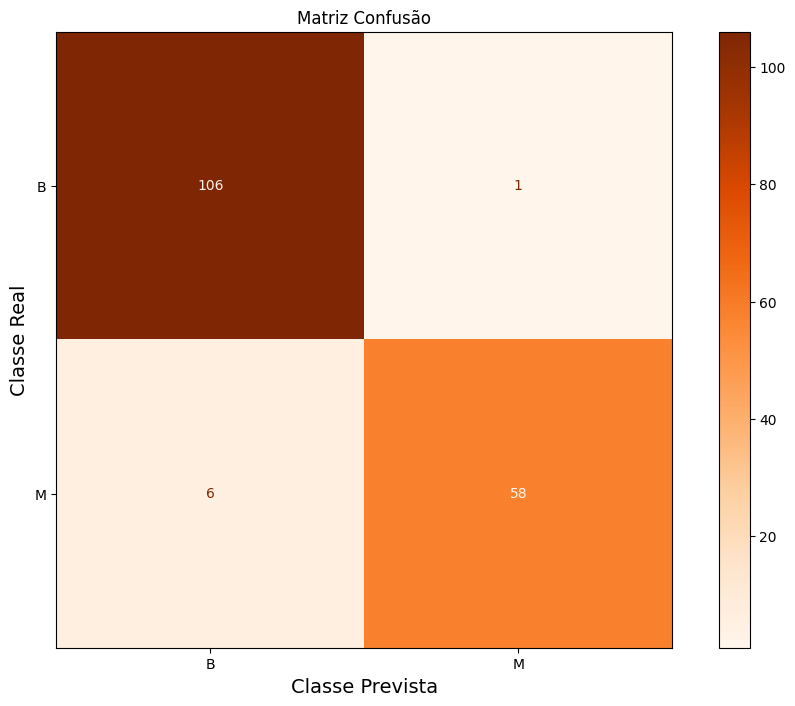

In [34]:
# Distância de Mahalanobis com n parâmetros da PCA
activity.loc['mahalanobis_pca'], conf_matrix_pca  = mahalanobis_classifier(x_train_pca, x_test_pca, y_train_bal, y_test)

disp_matriz(conf_matrix_pca, classes)

### <font color = yellow> Classificadores baseado no k-NN

#### <font color = lightyellow> ***00*** - Função para rodar o k-NN com diferentes conjuntos de features

In [35]:
def knn_classifier(x_train_bal, x_test, y_train_bal, y_test, k):
    """ Treina um classificador k-Nearest Neighbors (k-NN) usando os dados de treino balanceados,
    realiza previsões nos dados de teste e avalia o desempenho do modelo.  

    Args:
        x_train (array-like): Dados de treino usados para treinar o modelo.
        x_test (array-like): Dados de teste usados para avaliar o modelo.
        y_train (array-like): Rótulos das classes correspondentes aos dados de treino balanceados.
        y_test (array-like): Rótulos das classes correspondentes aos dados de teste.
        k (int): Número de vizinhos mais próximos a serem considerados pelo classificador k-NN.

    Return:
        metrics (list): Uma lista contendo as seguintes métricas de desempenho:
            - accuracy (float): A precisão do modelo, calculada como a proporção de previsões corretas.
            - sensitivity (float): A sensibilidade do modelo, calculada como a média das taxas de verdadeiros positivos por classe.
            - specificity (float): A especificidade do modelo, calculada como a média das taxas de verdadeiros negativos por classe.
        conf_matrix (array-like): A matriz de confusão, que mostra o desempenho do modelo em termos de 
        verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_bal, y_train_bal)
    y_pred = knn.predict(x_test)
    return performance_indicators(y_test, y_pred)

#### <font color = lightyellow> ***01*** - Utilizando todos os parâmetros de entrada

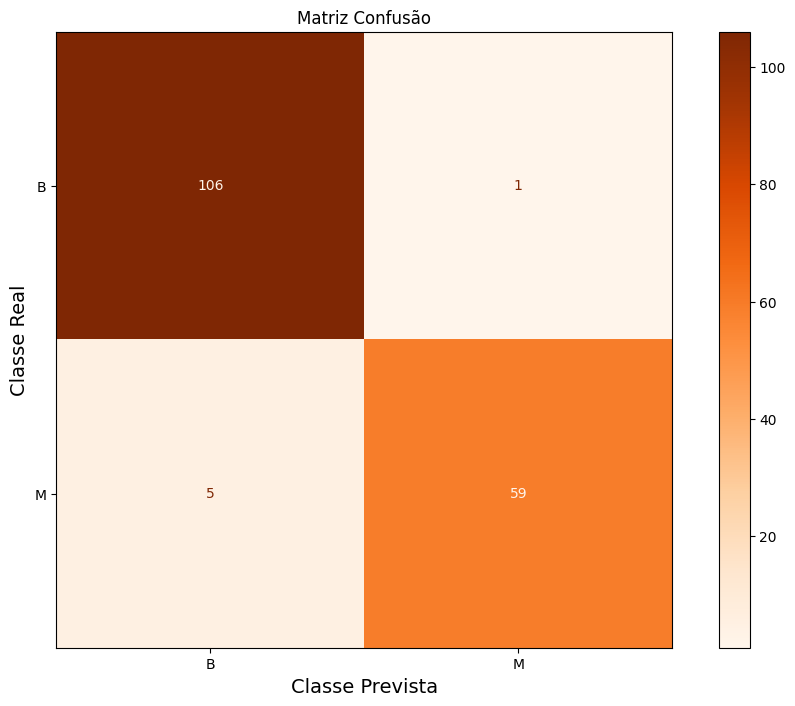

In [36]:
# avaliando o classificador com todos os parâmetros
activity.loc['knn'], conf_matrix_knn = knn_classifier(x_train_bal, x_test, y_train_bal, y_test, k)

disp_matriz(conf_matrix_knn, classes)

#### <font color = lightyellow> ***02*** - Utilizando os n parâmentros de maior correlação

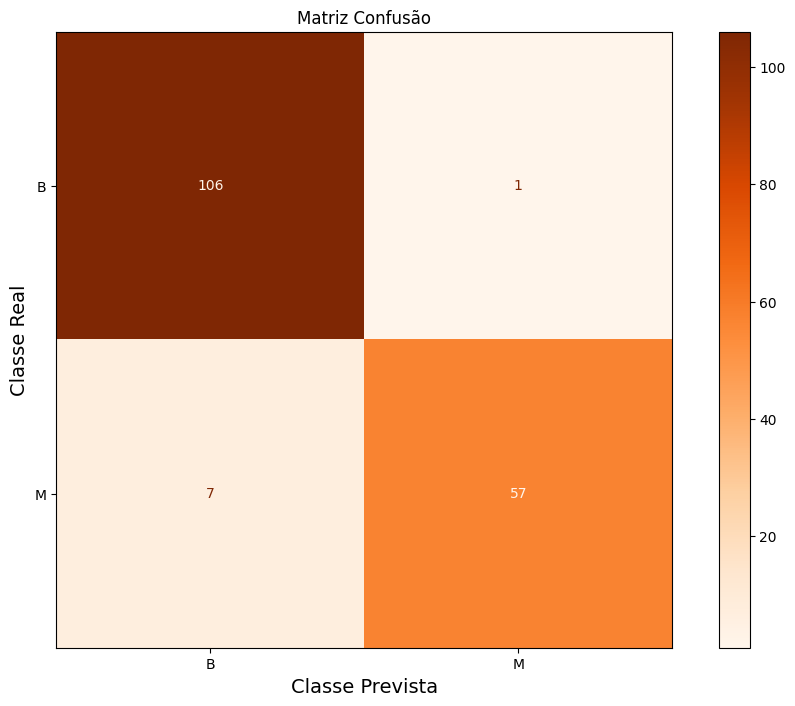

In [37]:
# k-NN com n parâmetros de maior correlação
activity.loc['knn_corr'], conf_matrix_knn_corr = knn_classifier(x_train_corr, x_test_corr, y_train_bal, y_test, k)

disp_matriz(conf_matrix_knn_corr, classes)

#### <font color = lightyellow> ***03*** - Utilizando os n parâmentros de maior informação mútua

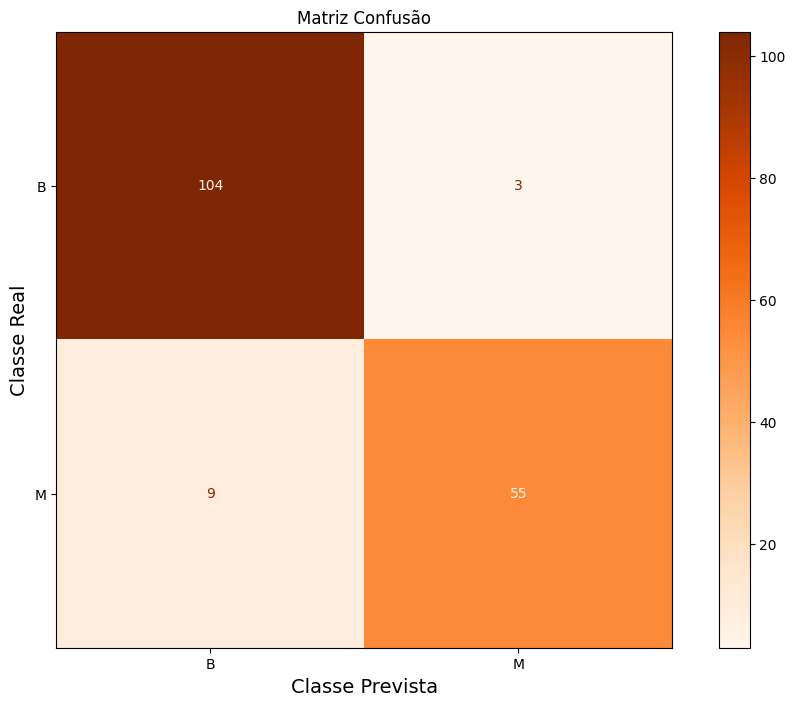

In [38]:
# k-NN com n parâmetros de maior informação mútua
activity.loc['knn_mutual'], conf_matrix_knn_mutual_info = knn_classifier(x_train_mutual_info, x_test_mutual_info, y_train_bal, y_test, k)

disp_matriz(conf_matrix_knn_mutual_info, classes)

#### <font color = lightyellow> ***04*** - Utilizando os n parâmentros de maior discriminante de Fisher

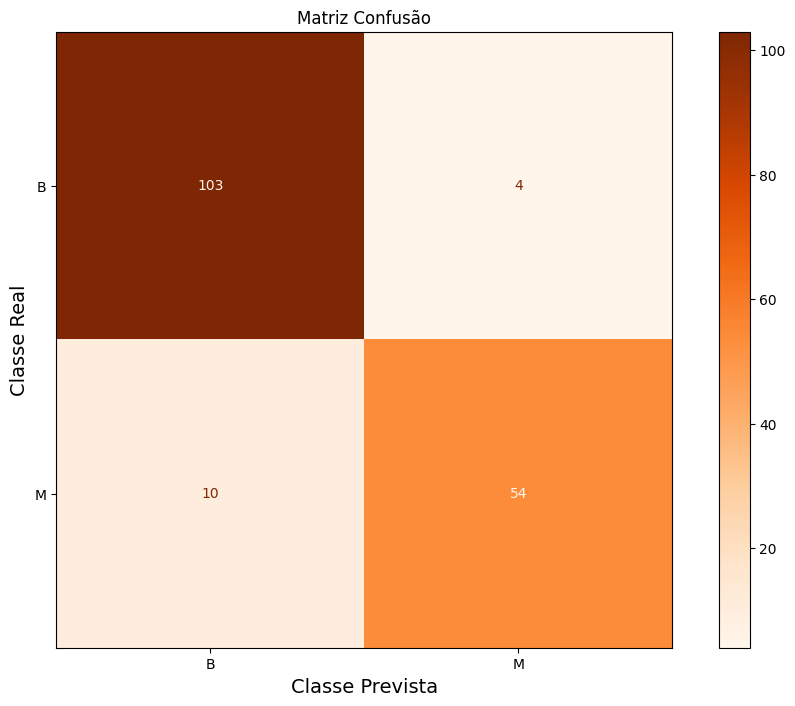

In [39]:
# k-NN com n parâmetros de maior razão discriminante de Fisher
activity.loc['knn_fisher'], conf_matrix_knn_fisher = knn_classifier(x_train_fisher, x_test_fisher, y_train_bal, y_test, k)

disp_matriz(conf_matrix_knn_fisher, classes)

#### <font color = lightyellow> ***05*** - Utilizando os n parâmentros do PCA

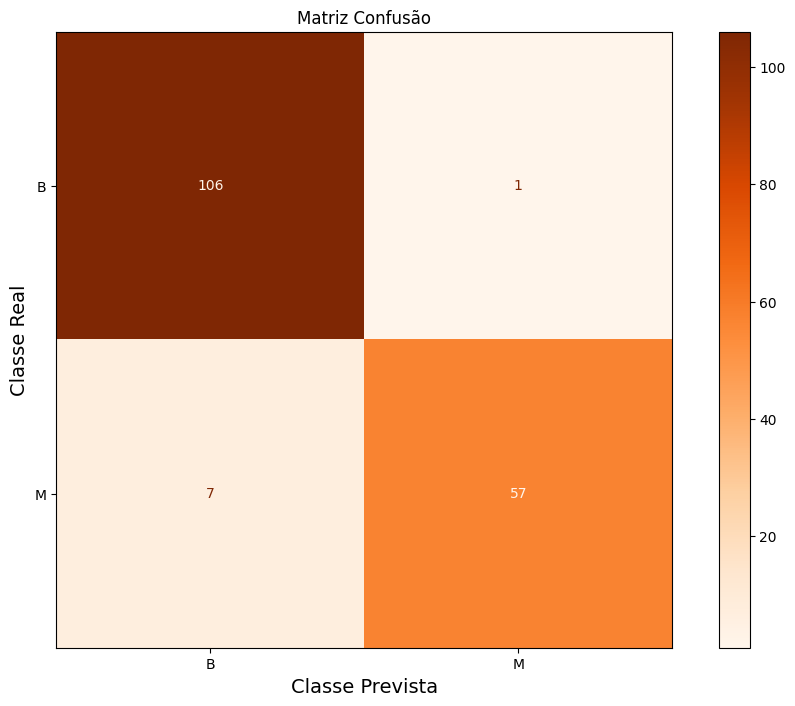

In [40]:
# k-NN com n parâmetros da PCA
activity.loc['knn_pca'], conf_matrix_knn_pca = knn_classifier(x_train_pca, x_test_pca, y_train_bal, y_test, k)

disp_matriz(conf_matrix_knn_pca, classes)

### <font color = yellow> Classificadores Linear

#### <font color = lightyellow> ***00*** -  Função para rodar o LDA com diferentes conjuntos de features

In [41]:
def lda_classifier(x_train, x_test, y_train, y_test):
    """ Treina um classificador Linear Discriminant Analysis (LDA) usando os dados de treino balanceados,
    realiza previsões nos dados de teste e avalia o desempenho do modelo.

    Args:
        x_train (array-like): Dados de treino usados para treinar o modelo.
        x_test (array-like): Dados de teste usados para avaliar o modelo.
        y_train (array-like): Rótulos das classes correspondentes aos dados de treino balanceados.
        y_test (array-like): Rótulos das classes correspondentes aos dados de teste.

    Return:
        metrics (list): Uma lista contendo as seguintes métricas de desempenho:
            - accuracy (float): A precisão do modelo, calculada como a proporção de previsões corretas.
            - sensitivity (float): A sensibilidade do modelo, calculada como a média das taxas de verdadeiros positivos por classe.
            - specificity (float): A especificidade do modelo, calculada como a média das taxas de verdadeiros negativos por classe.
        conf_matrix (array-like): A matriz de confusão, que mostra o desempenho do modelo em termos de 
        verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
    """
    lda = LinearDiscriminantAnalysis()
    lda.fit(x_train, y_train)
    y_pred = lda.predict(x_test)
    return performance_indicators(y_test, y_pred)

#### <font color = lightyellow> ***01*** - Utilizando todos os parâmetros de entrada

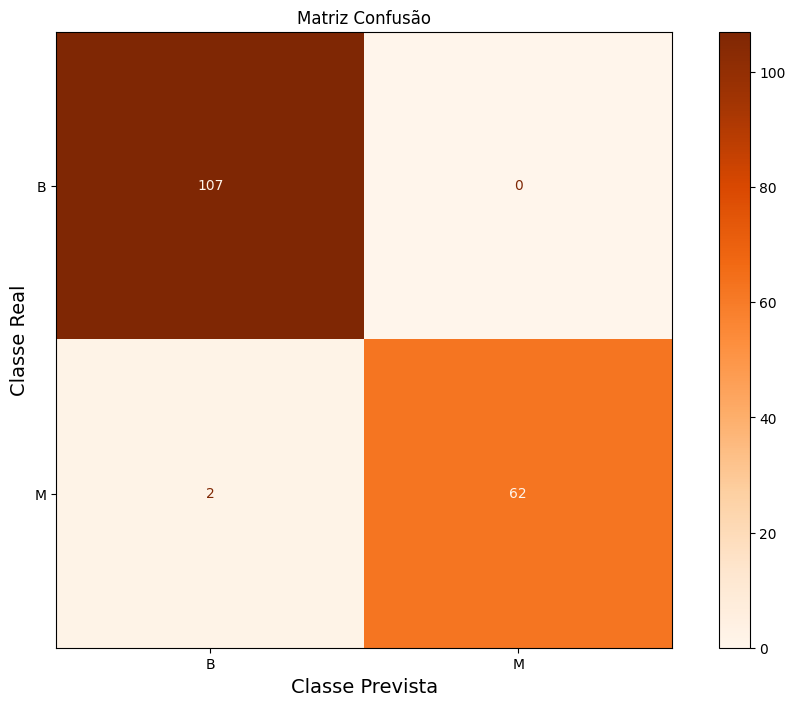

In [42]:
# avaliando o classificador com todos os parâmetros
activity.loc['lda'], conf_matrix_lda = lda_classifier(x_train_bal, x_test, y_train_bal, y_test)

disp_matriz(conf_matrix_lda, classes)

#### <font color = lightyellow> ***02*** - Utilizando os n parâmentros de maior correlação

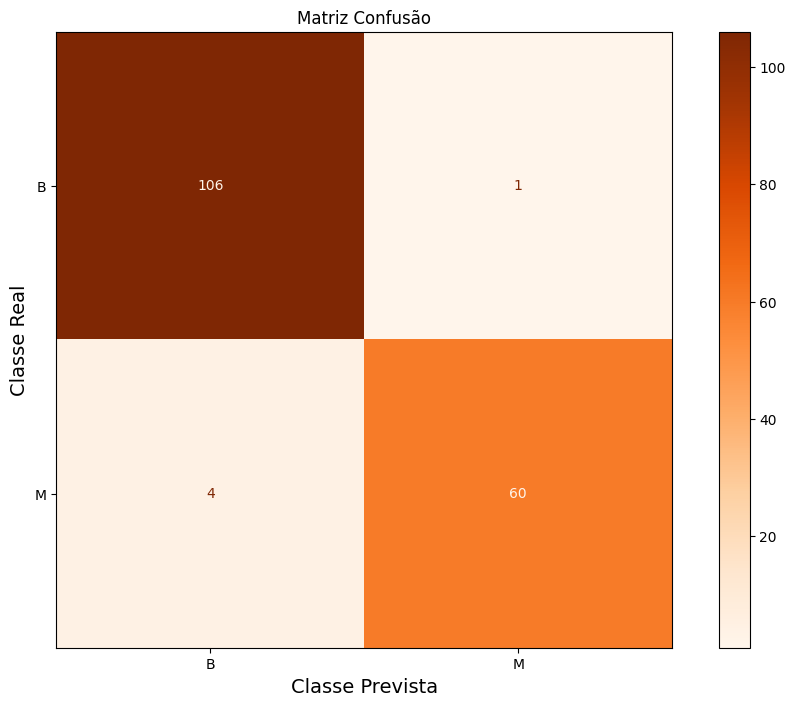

In [43]:
# LDA com n parâmetros de maior correlação
activity.loc['lda_corr'], conf_matrix_lda_corr = lda_classifier(x_train_corr, x_test_corr, y_train_bal, y_test)

disp_matriz(conf_matrix_lda_corr, classes)

#### <font color = lightyellow> ***03*** - Utilizando os n parâmentros de maior informação mútua

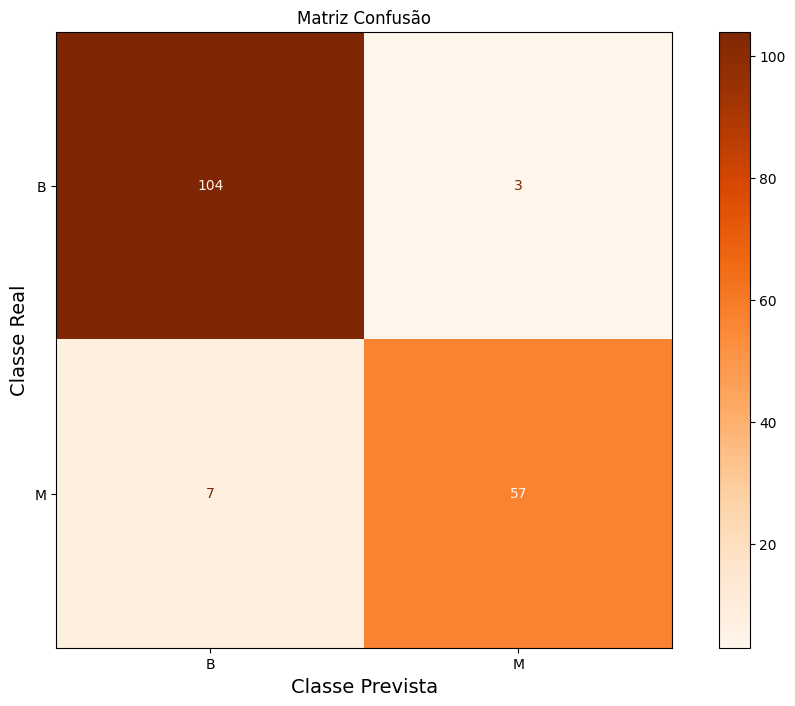

In [44]:
# LDA com n parâmetros de maior informação mútua
activity.loc['lda_mutual'], conf_matrix_lda_mutual_info = lda_classifier(x_train_mutual_info, x_test_mutual_info, y_train_bal, y_test)

disp_matriz(conf_matrix_lda_mutual_info, classes)

#### <font color = lightyellow> ***04*** - Utilizando os n parâmentros de maior discriminante de Fisher

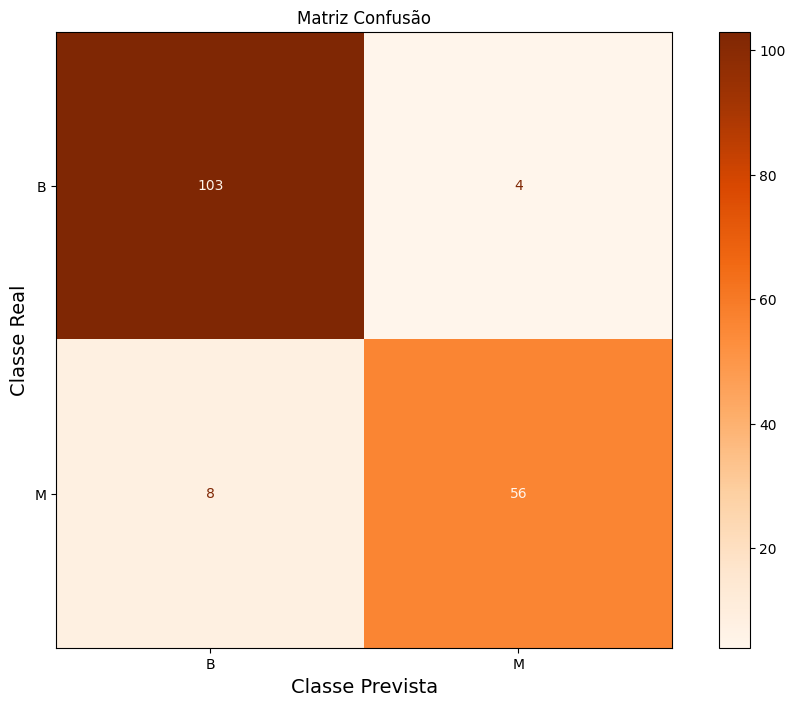

In [45]:
# LDA com n parâmetros de maior razão discriminante de Fisher
activity.loc['lda_fisher'], conf_matrix_lda_fisher = lda_classifier(x_train_fisher, x_test_fisher, y_train_bal, y_test)

disp_matriz(conf_matrix_lda_fisher, classes)

#### <font color = lightyellow> ***05*** - Utilizando os n parâmentros do PCA

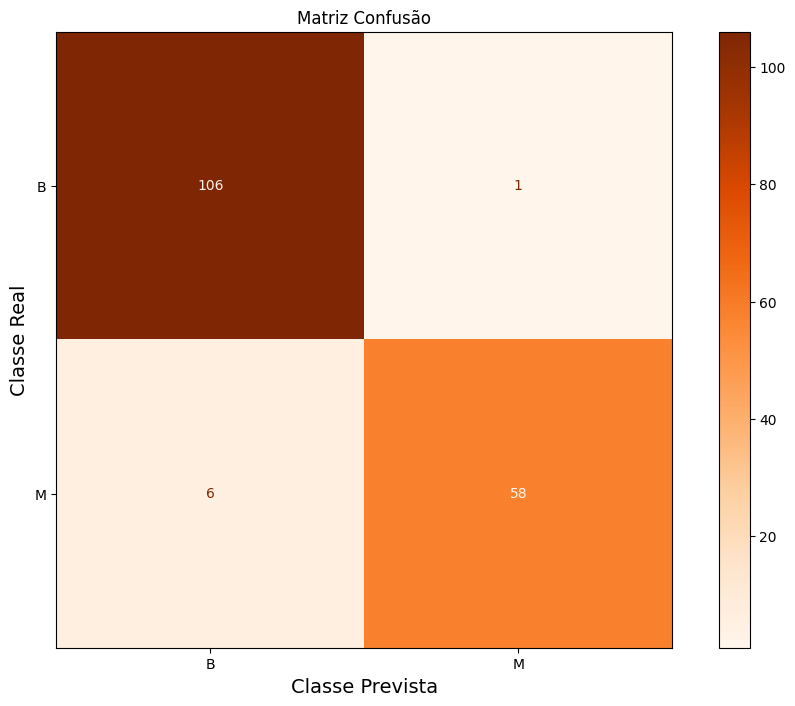

In [46]:
# LDA com n parâmetros da PCA
activity.loc['lda_pca'], conf_matrix_lda_pca = lda_classifier(x_train_pca, x_test_pca, y_train_bal, y_test)

disp_matriz(conf_matrix_lda_pca, classes)

### <font color = yellow> Classificadores baseado em uma rede neural MLP (Multilayer Perceptron)

#### <font color = lightyellow> ***00*** - Função para rodar a rede neural MLP com diferentes conjuntos de features

In [47]:
def mlp_classifier(x_train_bal, x_test, y_train_bal, y_test, max_inter, random_state):
    """ Treina um classificador baseado em rede neural MLP (Multilayer Perceptron) com uma camada oculta e 16 neurônios.
    Realiza previsões nos dados de teste e avalia o desempenho do modelo utilizando as métricas fornecidas pela função `performance_indicators`.

    Args:
        x_train (array-like): Dados de treino usados para treinar o modelo.
        x_test (array-like): Dados de teste usados para avaliar o modelo.
        y_train (array-like): Rótulos das classes correspondentes aos dados de treino balanceados.
        y_test (array-like): Rótulos das classes correspondentes aos dados de teste.
        max_inter (int): Máximo número de interações.
        random_state (int): Semente para o gerador de números randômicos, garantindo a reprodutibilidade
        
    Return:
        metrics (list): Uma lista contendo as seguintes métricas de desempenho:
            - accuracy (float): A precisão do modelo, calculada como a proporção de previsões corretas.
            - sensitivity (float): A sensibilidade do modelo, calculada como a média das taxas de verdadeiros positivos por classe.
            - specificity (float): A especificidade do modelo, calculada como a média das taxas de verdadeiros negativos por classe.
        conf_matrix (array-like): A matriz de confusão, que mostra o desempenho do modelo em termos de 
        verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
    """
    mlp = MLPClassifier(hidden_layer_sizes=(x_train_bal.shape[1],), max_iter=max_inter, random_state=random_state)
    mlp.fit(x_train_bal, y_train_bal)
    y_pred = mlp.predict(x_test)
    return performance_indicators(y_test, y_pred)

#### <font color = lightyellow> ***01*** - Utilizando todos os parâmetros de entrada

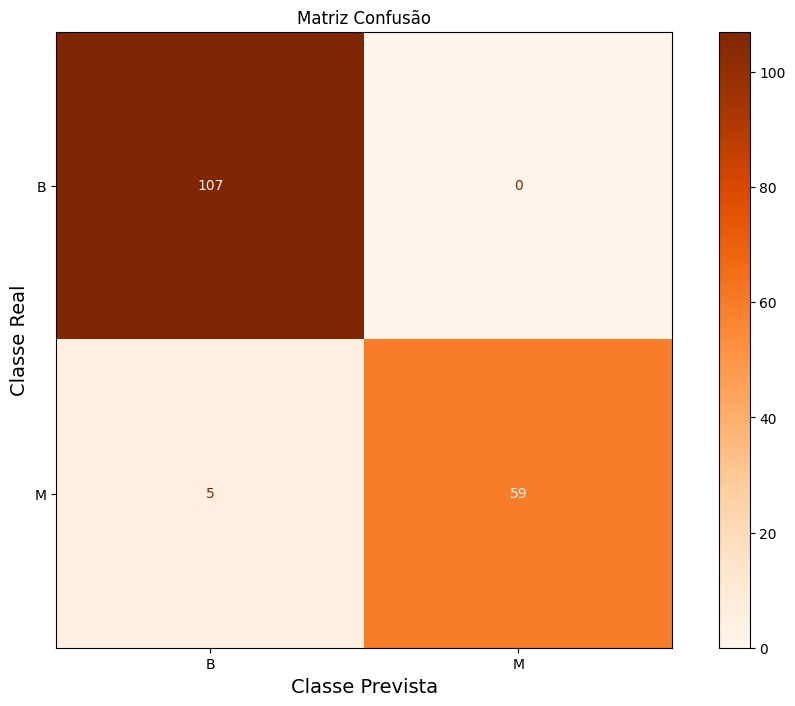

In [48]:
# avaliando o classificador com todos os parâmetros
activity.loc['mlp'], conf_matrix_mlp = mlp_classifier(x_train_bal, x_test, y_train_bal, y_test, max_inter, random_state)

disp_matriz(conf_matrix_mlp, classes)

### <font color = yellow> Classificadores baseado em máquinas de vetores de suporte não-linear (kernel função de base radial)

#### <font color = lightyellow> ***00*** - Função para rodar a SVM máquina de vetores de suporte não-linear com diferentes conjuntos de features

In [49]:
def svm_classifier(x_train_bal, x_test, y_train_bal, y_test, random_state):
    """ Treina um classificador SVM com kernel radial (RBF) usando os dados balanceados de treinamento e avalia seu desempenho.
    
    Args:
        x_train (array-like): Dados de treino usados para treinar o modelo.
        x_test (array-like): Dados de teste usados para avaliar o modelo.
        y_train (array-like): Rótulos das classes correspondentes aos dados de treino balanceados.
        y_test (array-like): Rótulos das classes correspondentes aos dados de teste.
        random_state (int): Semente para o gerador de números randômicos, garantindo a reprodutibilidade
        
    Return:
        metrics (list): Uma lista contendo as seguintes métricas de desempenho:
            - accuracy (float): A precisão do modelo, calculada como a proporção de previsões corretas.
            - sensitivity (float): A sensibilidade do modelo, calculada como a média das taxas de verdadeiros positivos por classe.
            - specificity (float): A especificidade do modelo, calculada como a média das taxas de verdadeiros negativos por classe.
        conf_matrix (array-like): A matriz de confusão, que mostra o desempenho do modelo em termos de 
        verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
    """
    svm = SVC(kernel='rbf', random_state=random_state)
    svm.fit(x_train_bal, y_train_bal)
    y_pred = svm.predict(x_test)
    return performance_indicators(y_test, y_pred)

#### <font color = lightyellow> ***01*** - Utilizando todos os parâmetros de entrada

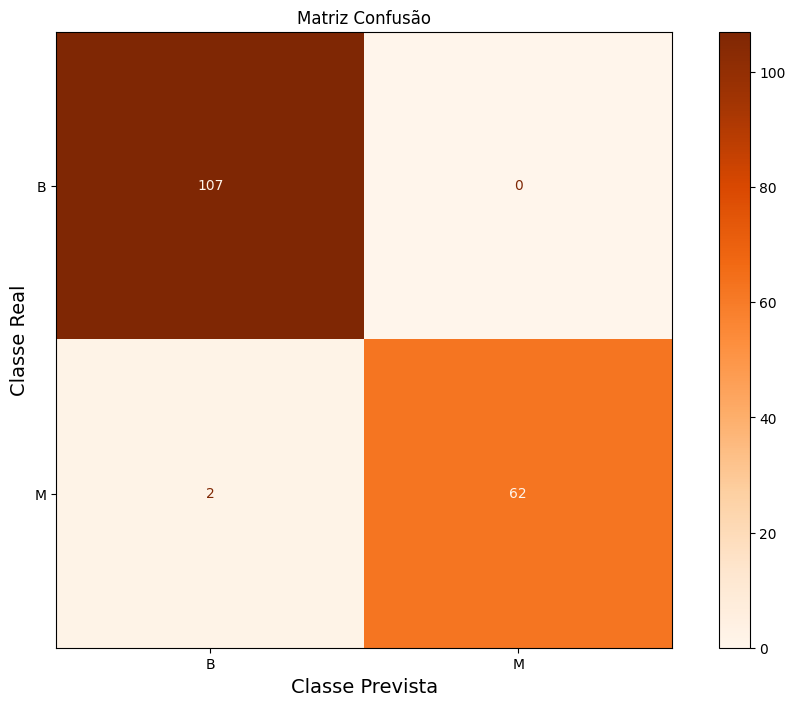

In [50]:
# avaliando o classificador com todos os parâmetros
activity.loc['svm'], conf_matrix_svm = svm_classifier(x_train_bal, x_test, y_train_bal, y_test, random_state)

disp_matriz(conf_matrix_svm, classes)

# <font color = green>***Considerações Finais***</font>

In [51]:
activity

,accuracy,sensitivity,caracteristic
mahalanobis,0.988304,0.984375,0.990826
mahalanobis_corr,0.97076,0.964077,0.973621
mahalanobis_mutual,0.94152,0.931294,0.943468
mahalanobis_fisher,0.929825,0.918808,0.930631
mahalanobis_pca,0.959064,0.948452,0.96474
knn,0.964912,0.956265,0.969144
knn_corr,0.953216,0.94064,0.960406
knn_mutual,0.929825,0.915669,0.934315
knn_fisher,0.918129,0.903183,0.921269
knn_pca,0.953216,0.94064,0.960406


In [52]:
print(f"Com base na \033[1;31macurâcia\033[0m o melhor projeto de classificador é o \033[1;33m{activity['accuracy'].idxmax()}\033[0m com valor de: \033[1;33m{activity['accuracy'].max():.3%}\033[0m")
print(f"Com base na \033[1;31msensibilidade\033[0m o melhor projeto de classificador é o \033[1;33m{activity['sensitivity'].idxmax()}\033[0m com valor de: \033[1;33m{activity['sensitivity'].max():.3%}\033[0m")
print(f"Com base na \033[1;31mespecificidades\033[0m o melhor projeto de classificador é o \033[1;33m{activity['caracteristic'].idxmax()}\033[0m com valor de: \033[1;33m{activity['caracteristic'].max():.3%}\033[0m")

Com base na acurâcia o melhor projeto de classificador é o mahalanobis com valor de: 98.830%
Com base na sensibilidade o melhor projeto de classificador é o mahalanobis com valor de: 98.438%
Com base na especificidades o melhor projeto de classificador é o mahalanobis com valor de: 99.083%
